注意力评分函数

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

掩蔽softmax操作

```
1.为什么需要掩蔽？ 
    在处理变长序列时，不同样本的序列长度不同。比如一个批次中有的句子3个词，有的句子5个词，但为了批处理需要padding到相同长度。我们不希望attention关注到这些padding位置。
2.掩蔽机制： 
    将无效位置的分数设为一个很大的负数（-1e6），这样经过softmax后，这些位置的注意力权重就接近0。
3.两种valid_lens格式：
    1D: [3, 2] 表示第一个样本有3个有效token，第二个有2个
    2D: 每行对应一个查询，可以有不同的有效长度

In [2]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
         # 如果没有提供有效长度信息，直接对最后一个维度做普通softmax
        return nn.functional.softmax(X, dim=-1)
    else:
         # 获取X的形状，比如(2, 4, 6)表示2个批次，4个查询，6个键
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了演示此函数是如何工作的， 考虑由两个2×4矩阵表示的样本， 这两个样本的有效长度分别为2和3。 经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。

In [6]:
z = torch.rand(2, 2, 4)
z

tensor([[[0.8298, 0.2216, 0.6630, 0.7535],
         [0.4182, 0.8968, 0.7088, 0.2385]],

        [[0.0184, 0.2796, 0.9917, 0.6447],
         [0.3385, 0.0969, 0.7592, 0.1217]]])

```
valid_lens = [2, 3] 的作用：
    [2, 3] 意思是：
    第1个样本只有前2个位置是有意义的
    第2个样本只有前3个位置是有意义的
    其他位置都是padding，应该被忽略
>softmax会重新分配概率

In [7]:
masked_softmax(z,torch.tensor([2,3]))

tensor([[[0.6476, 0.3524, 0.0000, 0.0000],
         [0.3826, 0.6174, 0.0000, 0.0000]],

        [[0.2022, 0.2626, 0.5352, 0.0000],
         [0.3023, 0.2374, 0.4604, 0.0000]]])

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。

In [8]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4822, 0.2189, 0.2989, 0.0000]],

        [[0.6639, 0.3361, 0.0000, 0.0000],
         [0.3114, 0.1595, 0.2398, 0.2893]]])

# 加性注意力

In [9]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

rand是均匀分布；normal是正态分布

```
# 对于形状 (1, 10, 4) 的张量：
# repeat(2, 1, 1) 意思是：
    #   ↑   ↑   ↑
    #   |   |   └─ 第2维（大小4）重复1次（不变）
    #   |   └───── 第1维（大小10）重复1次（不变） 
    #   └───────── 第0维（大小1）重复2次

In [10]:
queries = torch.normal(0, 1, (2, 1, 20))  # 随机生成
keys = torch.ones((2, 10, 2))             # 全是1
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
queries,keys,values,valid_lens

(tensor([[[-1.3622, -0.7674, -0.5338, -0.6036,  0.8984, -0.5799,  0.3450,
           -0.7133,  0.0058,  0.0523,  2.5383,  0.7258, -1.8446, -0.4174,
            0.7031,  0.4830,  1.0184,  0.2168,  0.7645,  1.4047]],
 
         [[ 1.0055, -1.8550,  1.6333,  0.2934, -0.1400, -0.0095, -0.6810,
            2.0570, -0.1235,  1.6198,  0.3533, -0.4440,  0.4406, -1.2013,
            0.0646, -2.0025,  0.4668, -0.1002, -0.9423, -0.2782]]]),
 tensor([[[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],
 
         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]]]),
 tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.],
          [16., 17., 18., 19.],


In [11]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval() # 切换到评估模式
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

```
# 你的需求 = queries
你说："我想要一些清爽的菜" 
# 就像 queries[0] = [-1.36, -0.76, ...] (你的需求向量)

# 菜品标签 = keys  
餐厅的所有菜都贴着标签：[清爽度, 营养度]
菜1标签: [1, 1] = 还行
菜2标签: [1, 1] = 还行  
菜3标签: [1, 1] = 还行
...所有菜的标签都一样 [1, 1]

# 菜品具体内容 = values
菜1: "凉拌黄瓜" = [0, 1, 2, 3] (卡路里, 维生素, 纤维, 满足感)
菜2: "蒸蛋羹"   = [4, 5, 6, 7]
菜3: "清汤面条" = [8, 9, 10, 11]
...

# 餐厅规则 = valid_lens
第1个顾客：只能从前2道菜中选 (valid_lens[0] = 2)
第2个顾客：只能从前6道菜中选 (valid_lens[1] = 6)

```
print("=== 第1个顾客 ===")
print("顾客需求：我想要清爽的菜")
print("服务员：好的，让我看看...")

print("可选菜品（前2道）：")
print("菜1: 凉拌黄瓜 [0卡, 1维C, 2纤维, 3满足感]")
print("菜2: 蒸蛋羹   [4卡, 5维C, 6纤维, 7满足感]")

print("服务员心里想：")
print("- 菜1标签[1,1]跟顾客需求匹配度: 还行")  
print("- 菜2标签[1,1]跟顾客需求匹配度: 还行")
print("- 两个都差不多，我各推荐一半吧")

print("最终推荐（混合）：")  
print("50% × 凉拌黄瓜 + 50% × 蒸蛋羹")
print("= 50% × [0,1,2,3] + 50% × [4,5,6,7]")
print("= [2,3,4,5] ← 这就是你的输出！")

```
print("=== 区分两种数据 ===")

# 数据1：最终输出结果（你看到的）
final_output = tensor([
    [[ 2.0000,  3.0000,  4.0000,  5.0000]],     # 第1个顾客得到的推荐
    [[10.0000, 11.0000, 12.0000, 13.0000]]     # 第2个顾客得到的推荐
])
print("最终输出（加权求和的结果）:", final_output)
print("这些数字加起来不等于1，因为它们是营养值的混合！")

# 数据2：注意力权重（内部计算，被保存在attention.attention_weights中）
attention_weights = tensor([
    [[0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],  # 第1个顾客的关注度
    [[0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.0, 0.0, 0.0, 0.0]]  # 第2个顾客的关注度  
])
print("注意力权重:", attention_weights)
print("这些权重每行加起来等于1！")

In [14]:
attention.attention_weights

tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]], grad_fn=<SoftmaxBackward0>)

🔍 关键理解：权重作用在向量上，不是标量上！

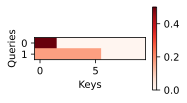

In [12]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# 缩放点积注意力

```
x = torch.tensor([1, 2, 3])   # shape: (3,)
y = x.unsqueeze(0)            # 在第0维插一个1 -> shape: (1, 3)
z = x.unsqueeze(1)            # 在第1维插一个1 -> shape: (3, 1)

In [15]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [16]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

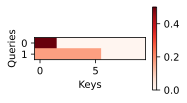

In [17]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

```
AdditiveAttention的处理方式（"翻译再比较"）：
print("=== AdditiveAttention处理过程 ===")

print("第1步：翻译成标准语言")
print("原始queries: [1, 2]")
print("原始keys:    [[3, 4], [5, 6]]")
print("")
print("经过W_q变换: [1, 2] -> [a1, a2, a3] (假设变成3维)")
print("经过W_k变换: [[3, 4], [5, 6]] -> [[b1, b2, b3], [c1, c2, c3]]")
print("现在都是3维了！可以比较了")

print("\n第2步：组合比较 (unsqueeze + 广播)")
print("queries.unsqueeze(2): 增加一个维度用于广播")
print("keys.unsqueeze(1):    增加一个维度用于广播")
print("然后相加: 每个query都和每个key组合")

print("\n第3步：计算相似度")
print("features = tanh(翻译后的query + 翻译后的key)")
print("scores = w_v(features)  # 压缩成1个分数")

```
DotProductAttention的处理方式（"直接比较"）：
print("\n=== DotProductAttention处理过程 ===")

print("第1步：直接计算")
print("queries: [1, 2]")  
print("keys:    [[3, 4], [5, 6]]")
print("不需要翻译！直接计算相似度")

print("\n第2步：点积计算")
print("query与key1的相似度: [1, 2] · [3, 4] = 1×3 + 2×4 = 11")
print("query与key2的相似度: [1, 2] · [5, 6] = 1×5 + 2×6 = 17") 
print("scores = [11, 17]")

print("\n第3步：缩放")
print("d = 2 (维度)")
print("scaled_scores = [11, 17] / √2 = [11/1.41, 17/1.41] = [7.8, 12.1]")

```
keys：形状通常为 (B, Lk, d)
keys.transpose(1, 2)：把 keys 的后两维互换 → 形状变为 (B, d, Lk)，这样就能和 (B, Lq, d) 做矩阵乘法了。

torch.bmm(A, B)：批量矩阵乘法（batch matrix multiply），要求 A 和 B 都是 3D 张量，分别形如 (B, n, m) 和 (B, m, p)，输出 (B, n, p)。
这里就是把每个 batch 里的 queries[b] @ keys[b].T 一次性算出来。

/ math.sqrt(d)：对点积结果做缩放，避免维度大时内积值过大，软最大化（softmax）变得过“尖锐”。这正是《Attention is All You Need》里的 scaled dot-product 做法。

In [18]:
print("=== 注意力机制进化史 ===")
print("📅 2015: Bahdanau Attention (就是你刚学的AdditiveAttention!)")  
print("         ↓")
print("📅 2017: Dot-Product Attention (你也学了!)")
print("         ↓") 
print("📅 2017: Multi-Head Attention (把点积注意力升级)")
print("         ↓")
print("📅 2017: Self-Attention (注意力的特殊用法)")
print("         ↓")
print("📅 2017: Transformer完整架构")

=== 注意力机制进化史 ===
📅 2015: Bahdanau Attention (就是你刚学的AdditiveAttention!)
         ↓
📅 2017: Dot-Product Attention (你也学了!)
         ↓
📅 2017: Multi-Head Attention (把点积注意力升级)
         ↓
📅 2017: Self-Attention (注意力的特殊用法)
         ↓
📅 2017: Transformer完整架构


In [19]:
print("\n=== Transformer中的实际过程 ===")
print("输入: 'The cat sat on the mat'")
print("")
print("第1步：转换为词向量")
print("the_vec = [0.1, 0.2, ...]")
print("cat_vec = [0.3, 0.4, ...]") 
print("sat_vec = [0.5, 0.6, ...]")
print("...")
print("")
print("第2步：通过线性变换生成Q, K, V")
print("# 对每个词向量都做变换")
print("Q_the = W_q @ the_vec")
print("K_the = W_k @ the_vec") 
print("V_the = W_v @ the_vec")
print("...")
print("")
print("第3步：计算attention")
print("# 每个词的query都和所有词的key计算相似度")
print("attention_scores = Q @ K.T")


=== Transformer中的实际过程 ===
输入: 'The cat sat on the mat'

第1步：转换为词向量
the_vec = [0.1, 0.2, ...]
cat_vec = [0.3, 0.4, ...]
sat_vec = [0.5, 0.6, ...]
...

第2步：通过线性变换生成Q, K, V
# 对每个词向量都做变换
Q_the = W_q @ the_vec
K_the = W_k @ the_vec
V_the = W_v @ the_vec
...

第3步：计算attention
# 每个词的query都和所有词的key计算相似度
attention_scores = Q @ K.T
